# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 



In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
df.head()

X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.020438  0.528451  0.0  0.914163 -0.765002 -2.712587  3  3   7.994218   
1 -1.202927  0.130721  1.0  0.700723 -0.047809 -0.726578  0  0  15.608856   
2  0.440919 -0.795397  1.0  0.775978 -1.302117 -1.762736  3  3  20.549045   
3  1.230233 -0.061368  1.0  0.202389 -0.241805 -2.088708  3  0  10.513453   
4 -1.598551  0.608297  1.0  0.587971 -1.421515 -0.604940  2  0  16.816861   

            y  
0   92.428728  
1   65.809569  
2  249.667566  
3  169.664302  
4   54.077915

In [3]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


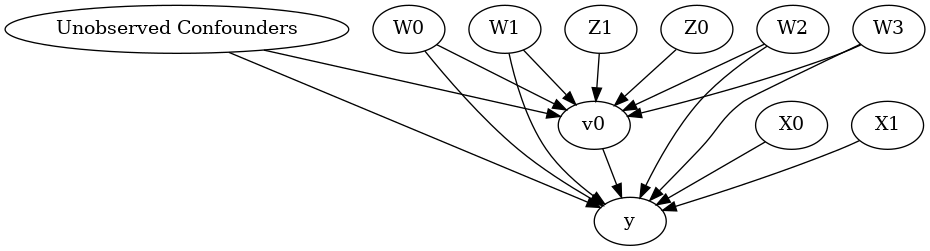

In [4]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [5]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                                    
─────(Expectation(y|W0,X1,W3,W2,W1,X0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,X1,W3,W2,W1,X0,U) = P(y|v0,W0,X1,W3,W2,W1,X0)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
  d                                 
─────(Expectation(y|W0,X1,W3,W2,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,X1,W3,W2,W1,U) = P(y|v0,W0,X1,W3,W2,W1)

### Estimand : 3
Estimand name: backdoor3
Estimand expression:
  d                                 
─────(Expectation(y|W0,W3,W2,W1,X0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,X0,U) = P(y|v0,W0,W3,W2,W1,X0)

### Estimand : 4
Estimand name: backdoor4
Estimand expression:
  d        

## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [6]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0+v0*X1+v0*X0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+X1+W3+W2+W1+X0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 10.289826051395593
### Conditional Estimates
__categorical__X1              __categorical__X0            
(-3.3819999999999997, -0.503]  (-3.5669999999999997, -0.836]     2.769112
                               (-0.836, -0.225]                  6.825982
                               (-0.225, 0.266]                   9.377288
                               (0.266, 0.857]                   11.880354
                               (0.857, 3.583]                   15.895080
(-0.503, 0.0804]               (-3.5669999999999997, -0.836]     3.433273
                               (-0.836, -0.225]                  7.454798
                               (-0.225, 0.266]                  10.005408
                               (0.266, 0.857]                   12.426070
                               (0.857, 3.583

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DMLCateEstimator". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 17.171634444490774
Effect estimates: [15.61178484 16.68011577 20.4769992  ... 15.10173708 19.19292624
 14.23641882]



In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 10.28982957507499


In [9]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
Target units: 

## Estimate
Mean value: 10.196536397917297
Effect estimates: [10.35480369  4.43225691 11.43962706 ... 11.52322586  5.74919866
 12.6065523 ]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    9.4s remaining:   21.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    9.4s remaining:    4.0s


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
Target units: ate

## Estimate
Mean value: 10.23367138762885
Effect estimates: [10.39436064  4.44345901 11.47175756 ... 11.56362583  5.74802898
 12.65430729]
95.0% confidence interval: (array([10.27935888,  4.45438846, 11.29194072, ..., 11.4159319 ,
        5.67829885, 12.48113385]), array([10.39003714,  4.57589999, 11.49646702, ..., 11.56800329,
        5.88462184, 12.64997284]))

[10.39436064  4.44345901 11.47175756 15.62768401  2.92075562 13.64386409
  7.60485042  3.2575185  10.68773978 14.37565172]
(array([10.27935888,  4.45438846, 11.29194072, ..., 11.4159319 ,
        5.67829885, 12.48113385]), array([10.39003714,  4.57589999, 11.49646702, ..., 11.56800329,
        5.88462184, 12.64997284]))


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


### Can provide a new inputs as target units and estimate CATE on them.

In [11]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0


[12.70686496 13.29604226 14.45538533 14.08504563 14.82337538 11.45486938
 12.46671782 13.7903808  11.58381091 14.30085111]


### Can also retrieve the raw EconML estimator object for any further operations

In [12]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Continuous treatment, Continuous outcome

This method is computationally intensive, may take a while depending on your machine. 

In [13]:
from sklearn.linear_model import LogisticRegression
orthoforest_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'n_trees':2, # not ideal, just as an example to speed up computation
                                                    },
                                               "fit_params":{}
                                              })
print(orthoforest_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1136 t

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 17.356885905566333
Effect estimates: [14.56514872 17.58481163 21.36692314 ... 15.29894085 20.04035586
 12.48323249]



[Parallel(n_jobs=-1)]: Done 1632 out of 1632 | elapsed:  5.6min finished


### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.857468  0.902003  1.0  0.813743 -0.202984 -2.759156 -1.679577   
1    -1.222928  1.397139  1.0  0.574540 -0.713438 -0.182368  1.030861   
2    -0.684620 -1.271648  1.0  0.062960 -1.495873 -0.387853 -0.080516   
3    -1.084030  1.508654  1.0  0.185505 -0.091422 -0.476764 -0.072984   
4    -1.454599  2.217028  1.0  0.576932 -0.698251  0.903661  1.196306   
...        ...       ...  ...       ...       ...       ...       ...   
9995  0.062914  0.443736  1.0  0.950825  1.366133 -1.808942 -2.744749   
9996 -1.803521  0.724647  1.0  0.017332 -0.598770  1.132992 -0.452070   
9997 -1.815662  0.635427  1.0  0.617730  1.384554 -0.056143 -2.574848   
9998 -0.112852  0.054143  1.0  0.297388 -1.458090 -1.322138 -0.369988   
9999 -1.312036  0.124026  1.0  0.676653 -1.297546  0.653916  1.085150   

            W3  v0  y  
0     1.609308   1  1  
1     0.547863   1  1  
2    -0.599447   1  0  
3     0.349878   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.9046964398828231
Effect estimates: [0.98732169 0.86104482 0.74706927 0.60909795 0.48963887 1.31035473
 1.24498447 0.72784302 1.134212   1.17814957 0.98129879 0.90393852
 1.11146773 0.91911049 1.01090887 1.13024438 0.54258659 0.79981609
 0.82406848 1.03796007 0.79016101 1.26290143 0.64293109 0.88396406
 0.67649434 1.04470024 0.82959912 0.79661992 0.87031547 1.21193036
 0.90444846 1.08652597 0.89682558 1.07210495 0.74864264 0.91040557
 0.634132   1.28772    0.65430327 0.99927764 0.62201892 0.55003477
 0.51726932 0.7960831  1.23126346 0.97151554 0.96306413 0.83716338
 0.93283008 1.04579244 1.21007929 1.25822157 1.08056368 0.69822537
 0.98460404 1.088023   0.51067753 1.12070291 0.96884641 0.84304086
 0.9073033  0.59938126 0.96630429 1.18076692 1.22978282 0.51331991
 0.96074041 1.09

### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model._instruments)+len(model._effect_modifiers)
dims_tx = len(model._treatment)+len(model._effect_modifiers)
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0


Epoch 1/25
10000/10000 [==============================] - 1s 101us/step - loss: 5.6563
Epoch 2/25
10000/10000 [==============================] - 1s 64us/step - loss: 2.8784
Epoch 3/25
10000/10000 [==============================] - 1s 64us/step - loss: 1.9167
Epoch 4/25
10000/10000 [==============================] - 1s 63us/step - loss: 1.7605
Epoch 5/25
10000/10000 [==============================] - 1s 65us/step - loss: 1.6946
Epoch 6/25
10000/10000 [==============================] - 1s 58us/step - loss: 1.6383
Epoch 7/25
10000/10000 [==============================] - 1s 62us/step - loss: 1.5963
Epoch 8/25
10000/10000 [==============================] - 1s 61us/step - loss: 1.5739
Epoch 9/25
10000/10000 [==============================] - 1s 60us/step - loss: 1.5754
Epoch 10/25
10000/10000 [==============================] - 1s 60us/step - loss: 1.5291
Epoch 11/25
10000/10000 [==============================] - 1s 59us/step - loss: 1.5353
Epoch 12/25
10000/10000 [==========================

### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(10, num_common_causes=0, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=4,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
data_experiment['df'].y = data_experiment['df'].y.astype(int)
print(data_experiment['df'])

model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


            X0        X1        X2        X3   Z0        Z1  v0  y
0    -0.464795  1.002648 -0.833063  0.356187  1.0  0.343335   1  1
1     0.392936 -0.736792  0.657846 -0.066270  1.0  0.159672   1  1
2    -3.647063  0.201819  0.087180 -0.020421  1.0  0.267230   1  0
3    -2.053150  0.690551  1.109607 -0.273678  1.0  0.537687   1  1
4     0.433543 -0.591914  0.817199 -0.784008  1.0  0.876465   1  1
...        ...       ...       ...       ...  ...       ...  .. ..
9995 -0.929409  1.328642  0.544286 -0.819403  0.0  0.139637   1  1
9996 -1.049198  0.214327 -0.242168  0.637564  0.0  0.855527   1  1
9997 -0.214810 -1.682216  2.302478 -0.801219  1.0  0.468263   1  1
9998 -1.789588 -1.980676 -1.436301 -0.834215  0.0  0.706576   1  0
9999 -0.372375  1.255655 -1.642403 -1.328467  0.0  0.605626   1  1

[10000 rows x 8 columns]


In [18]:
from sklearn.linear_model import LogisticRegressionCV
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                target_units = lambda df: df["X0"]>1, 
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X2+X1+X3+X0 | X2,X3,X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X2+X1+X3+X0 | X2,X3,X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.0
Effect estimates: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Refuting the estimate

### Random 

In [19]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0


Refute: Add a Random Common Cause
Estimated effect:13.296334356793176
New effect:13.358289702983607



### Adding an unobserved common cause variable

In [20]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0


Refute: Add an Unobserved Common Cause
Estimated effect:13.296334356793176
New effect:13.324428024823797



### Replacing treatment with a random (placebo) variable

In [21]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_e

INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dow

Refute: Use a Placebo Treatment
Estimated effect:13.296334356793176
New effect:0.013601470163468696
p value:0.71



### Removing a random subset of the data

In [22]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 8000.0 each
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+X1+W3+W2+W1+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML E

Refute: Use a subset of data
Estimated effect:13.296334356793176
New effect:13.286368156471026
p value:0.37



More refutation methods to come, especially specific to the CATE estimators.